In [1]:
!pip install torchvision
!pip install --upgrade transformers
!pip install mmocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [2]:
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

zipPath = '/content/drive/MyDrive/train_val_images.zip'
zipPathTest = '/content/drive/MyDrive/test_images.zip'
annsPathTrain = '/content/drive/MyDrive/TextOCR_0.1_train.json'
annsPathVal = '/content/drive/MyDrive/TextOCR_0.1_val.json'
annsPathTest = '/content/drive/MyDrive/TextOCR_0.1_test.json'
stepDir = "/content/drive/MyDrive/checkpoint_coreset/donut/"

diversityPath = "/content/drive/MyDrive/Core-sets/DiversityClustering.zip"
annsDiversity = "/content/drive/MyDrive/Core-sets/DiversityClustering.json"
hardPath = "/content/drive/MyDrive/Core-sets/HardClustering.zip"
annsHard = "/content/drive/MyDrive/Core-sets/HardClustering.json"

Mounted at /content/drive


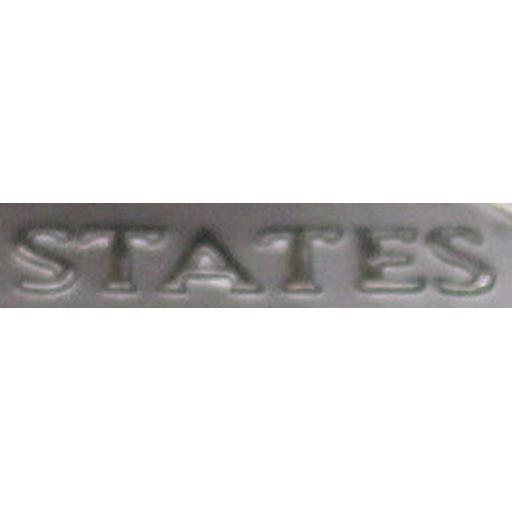

In [4]:
import zipfile
from PIL import Image
from IPython.display import display
import io

data = zipfile.ZipFile(diversityPath, 'r')
images = [f for f in data.namelist() if f.endswith('.jpg')]
file = data.open(images[0])
img = Image.open(io.BytesIO(file.read())).convert("RGB")
display(img)

In [ ]:
from transformers import VisionEncoderDecoderModel, DonutProcessor

if os.path.exists("/content/drive/MyDrive/models_coreset/model"):
  model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/models_coreset/model")
elif os.path.exists(stepDir):
  model = VisionEncoderDecoderModel.from_pretrained(stepDir)
else:
  model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
processor.feature_extractor.size = {"height": 512, "width": 512}
print(processor.image_processor.size)

In [ ]:
from PIL import ImageOps
import json
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import numpy as np
import random

class CoreDataset(Dataset):
  def __init__(self, zipPath, annsPath, processor, isTest, maxLength = 50, maxSamples = None):
    self.zipPath = zipPath
    self.annsPath = annsPath
    self.processor = processor
    self.maxLength = maxLength
    self.archive = zipfile.ZipFile(self.zipPath, 'r')

    with open(self.annsPath, 'r') as f:
      self.annotations = json.load(f)

    with zipfile.ZipFile(zipPath, 'r') as zipRef:
      filenames = zipRef.namelist()

    self.samples = []
    idx = 0
    for label in self.annotations:
      self.samples.append((filenames[idx], label))
      if len(self.samples) == maxSamples:
        break
      idx += 1


  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    zipImgPath, label = self.samples[idx]
    with self.archive.open(zipImgPath) as f:
      img = Image.open(io.BytesIO(f.read())).convert("RGB")
    pixelValues = self.processor(img, return_tensors = "pt").pixel_values[0]
    labels = self.processor.tokenizer(label, max_length = self.maxLength, padding = "max_length", truncation = True, return_tensors = "pt").input_ids.squeeze(0)
    labels[labels == self.processor.tokenizer.pad_token_id] = -100
    return {"pixel_values": pixelValues, "labels": labels}

  def sendItem(self, idx):
    zipImgPath, label = self.samples[idx]
    with self.archive.open(zipImgPath) as f:
      img = Image.open(io.BytesIO(f.read())).convert("RGB")
    return img, label

  def printLabel(self, idx):
    _ , label = self.samples[idx]
    print(label)

In [ ]:
from PIL import ImageOps

def resizeMaintainRatio(image, size=(1920, 2560)):
  w, h = image.size
  scale = min(size[0] / w, size[1] / h)
  newW, newH = int(w * scale), int(h * scale)
  newImg = image.resize((newW, newH))

  deltaW = size[0] - newW
  deltaH = size[1] - newH
  padding = (deltaW // 2, deltaH // 2, deltaW - (deltaW // 2), deltaH - (deltaH // 2))
  newImg = ImageOps.expand(newImg, padding, fill = (255, 255, 255))
  return newImg

In [ ]:
class ZippedDataset(Dataset):
  def __init__(self, zipPath, annsPath, processor, isTest, maxLength = 50, maxSamples = None):
    self.zipPath = zipPath
    self.annsPath = annsPath
    self.processor = processor
    self.maxLength = maxLength
    self.archive = zipfile.ZipFile(self.zipPath, 'r')

    with open(self.annsPath, 'r') as f:
      annotations = json.load(f)
    self.imgs = annotations["imgs"]
    self.anns = annotations["anns"]

    self.samples = []
    minBox = (20, 20)
    img = None
    curImgID = ""
    for ann in self.anns.values():
      imgID = ann["image_id"]
      text = ann["utf8_string"].strip()
      bbox = ann["bbox"]
      zipImgPath = self.imgs[imgID]["file_name"]
      zipImgPath = zipImgPath.replace("test/", "test_images/") if isTest else zipImgPath.replace("train/", "train_images/")
      if img is None or imgID != curImgID:
        with self.archive.open(zipImgPath) as f:
          img = Image.open(io.BytesIO(f.read())).convert("RGB")
        curImgID = imgID
      x, y, w, h = bbox
      if w < minBox[0] or h < minBox[1]:
        continue
      cropped = img.crop((x, y, x + w, y + h))
      if self.tooBlurry(cropped) or text == "" or text == ".":
        continue
      self.samples.append((zipImgPath, bbox, text))
      if len(self.samples) == maxSamples:
        break

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    zipImgPath, bbox, label = self.samples[idx]
    with self.archive.open(zipImgPath) as f:
      img = Image.open(io.BytesIO(f.read())).convert("RGB")
    x, y, w, h = bbox
    cropped = img.crop((x, y, x + w, y + h))
    cropped = resizeMaintainRatio(cropped, (512, 512))
    pixelValues = self.processor(cropped, return_tensors = "pt").pixel_values[0]
    labels = self.processor.tokenizer(label, max_length = self.maxLength, padding = "max_length", truncation = True, return_tensors = "pt").input_ids.squeeze(0)
    labels[labels == self.processor.tokenizer.pad_token_id] = -100
    return {"pixel_values": pixelValues, "labels": labels}

  def sendItem(self, idx):
    zipImgPath, bbox, label = self.samples[idx]
    with self.archive.open(zipImgPath) as f:
      img = Image.open(io.BytesIO(f.read())).convert("RGB")
    x, y, w, h = bbox
    cropped = img.crop((x, y, x + w, y + h))
    cropped = resizeMaintainRatio(cropped, (512, 512))
    return cropped, label

  def tooBlurry(self, img, threshold = 100):
    img = np.array(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian < threshold

  def printLabel(self, idx):
    _ , label = self.samples[idx]
    print(label)

In [ ]:
from torch.utils.data import random_split
import torch

datasetTrain = CoreDataset(hardPath, annsHard, processor, False)
generator = torch.Generator().manual_seed(44)
datasubTrain, datasubVal = random_split(datasetTrain, [int(len(datasetTrain) * 0.9), len(datasetTrain) - int(len(datasetTrain) * 0.9)], generator = generator)
dataloaderTrain = DataLoader(datasubTrain, batch_size = 24, shuffle = True)
dataloaderVal = DataLoader(datasubVal, batch_size = 1)
print(len(datasubTrain))
print(len(datasubVal))

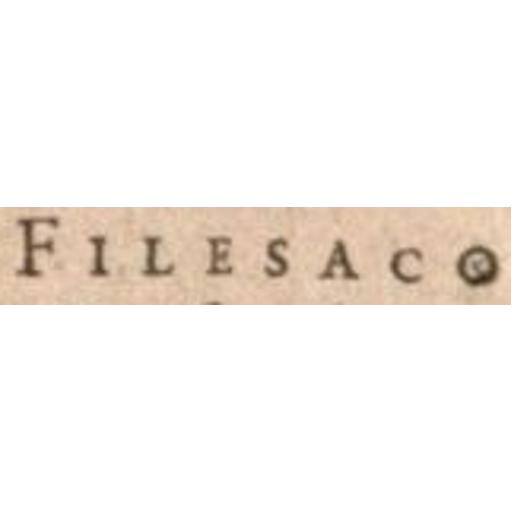

FILESACO


In [ ]:
img, label = datasetTrain.sendItem(10)
display(img)
print(label)

In [ ]:
model.config.decoder_start_token_id = processor.tokenizer.bos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.eos_token_id

print("Decoder start token:", processor.tokenizer.convert_ids_to_tokens(model.config.decoder_start_token_id))
print("Pad token:", processor.tokenizer.pad_token, "ID:", model.config.pad_token_id)
print("EOS token:", processor.tokenizer.eos_token, "ID:", model.config.eos_token_id)

Decoder start token: <s>
Pad token: <pad> ID: 1
EOS token: </s> ID: 2


In [ ]:
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

numEpochs = 3
accumulationSteps = 4
numTrainingSteps = numEpochs * len(dataloaderTrain)
optimizer = AdamW(model.parameters(), lr = 2e-5, weight_decay=0.01)
lrScheduler = get_linear_schedule_with_warmup(optimizer = optimizer, num_warmup_steps = 1000, num_training_steps = numTrainingSteps)
if os.path.exists(stepDir):
  optimizer.load_state_dict(torch.load(os.path.join(stepDir, "optimizer.pt")))
  lrScheduler.load_state_dict(torch.load(os.path.join(stepDir, "lrScheduler.pt")))

In [ ]:
import gc
import torch

torch.cuda.empty_cache()
gc.collect()
torch.cuda.ipc_collect()

In [ ]:
class EarlyStopping:
  def __init__(self, patience = 1, delta = 0):
    self.patience = patience
    self.delta = delta
    self.counter = 0
    self.bestLoss = float("inf")
    self.earlyStop = False

  def __call__(self, valLoss):
    if valLoss < self.bestLoss - self.delta:
      self.bestLoss = valLoss
      self.counter = 0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        self.earlyStop = True

In [ ]:
import torch.nn.functional as F

def labelSmoothedNLLLoss(logits, target, epsilon = 0.1, ignoreIdx = -100):
  target = torch.clamp(target, 0, logits.size(-1) - 1)
  mask = target != ignoreIdx
  logProbs = F.log_softmax(logits, dim = -1)
  nClasses = logits.size(-1)
  trueDist = torch.zeros_like(logProbs)
  trueDist.fill_(epsilon / (nClasses - 1))
  trueDist.scatter_(2, target.unsqueeze(-1), 1 - epsilon)
  loss = -(trueDist * logProbs).sum(dim = -1)
  loss = loss[mask]
  return loss.mean()

def tokenConfidencePenalty(logits):
  logProbs = F.log_softmax(logits, dim = -1)
  entropy = -torch.sum(torch.exp(logProbs) * logProbs, dim = -1)
  return entropy.mean()

In [ ]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
earlyStopper = EarlyStopping(patience = 0)
model.gradient_checkpointing_enable()
if os.path.exists(stepDir):
  with open(os.path.join(stepDir, "meta.json"), "r") as f:
    meta = json.load(f)
  globalStep = meta.get("global_step", 0)
  startEpoch = meta.get("epoch", 0)
else:
  globalStep = 0
  startEpoch = 0
lenPenalty = 0.05

for epoch in range(startEpoch, numEpochs):
  print(f"Epoch {epoch + 1}/{numEpochs}")
  runningLoss = 0.0
  model.train()
  optimizer.zero_grad()
  trainLoss = 0.0
  pbar = tqdm(dataloaderTrain, desc = "Training")
  for step, batch in enumerate(pbar):
    batch = {k: v.to(device) for k, v in batch.items()}
    with autocast(enabled = True):
      outputs = model(**batch)
      logits = outputs.logits
      labels = batch["labels"]
      loss = labelSmoothedNLLLoss(logits, labels, epsilon = 0.1)
      predictedIDs = logits.detach().argmax(dim = -1)
      predictedLengths = (predictedIDs != processor.tokenizer.pad_token_id).sum(dim = 1).float()
      avgLength = predictedLengths.mean()
      loss = loss + lenPenalty * avgLength
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    lrScheduler.step()
    optimizer.zero_grad()

    runningLoss += loss.item()
    pbar.set_postfix(loss = runningLoss / (step + 1))

  del loss, outputs, batch
  gc.collect()
  avgTrainLoss = runningLoss / len(dataloaderTrain)
  print(f"Training loss: {avgTrainLoss:.4f}")

  model.eval()
  valLoss = 0.0
  with torch.no_grad():
    for batch in dataloaderVal:
      batch = {k: v.to(device) for k, v in batch.items()}
      with autocast(enabled = True):
        outputs = model(**batch)
        loss = outputs.loss
      valLoss += loss.item()
  avgValLoss = valLoss / len(dataloaderVal)
  print(f"Validation loss: {avgValLoss:.4f}")
  earlyStopper(avgValLoss)
  if earlyStopper.earlyStop:
    print("Early stopping!")
    break

  os.makedirs(stepDir, exist_ok = True)
  model.save_pretrained(stepDir)
  processor.save_pretrained(stepDir)
  torch.save(optimizer.state_dict(), os.path.join(stepDir, "optimizer.pt"))
  torch.save(lrScheduler.state_dict(), os.path.join(stepDir, "lrScheduler.pt"))
  with open(os.path.join(stepDir, "meta.json"), "w") as f:
    json.dump({"global_step": globalStep, "epoch": epoch}, f)

  torch.cuda.empty_cache()
  del loss, outputs, batch
  gc.collect()
  torch.cuda.ipc_collect()

<ipython-input-19-aaa14dfb309c>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/3


Training:   0%|          | 0/290 [00:00<?, ?it/s]<ipython-input-19-aaa14dfb309c>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled = True):
`use_cache=True` is incompatible with gradient checkpointing`. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
Training: 100%|██████████| 290/290 [11:50<00:00,  2.45s/it, loss=6.68]
<ipython-input-19-aaa14dfb309c>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled = True):
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Training loss: 6.6822
Validation loss: 7.5050
Epoch 2/3


Training: 100%|██████████| 290/290 [11:44<00:00,  2.43s/it, loss=4.36]


Training loss: 4.3634
Validation loss: 6.2933
Epoch 3/3


Training: 100%|██████████| 290/290 [11:45<00:00,  2.43s/it, loss=4.19]


Training loss: 4.1918
Validation loss: 7.9510
Early stopping!


In [ ]:
model.save_pretrained("/content/drive/MyDrive/models_coreset/hard_model")

In [ ]:
datasetTest = ZippedDataset(zipPath, annsPathVal, processor, False, maxSamples = 4000)
dataloaderTest = DataLoader(datasetTest, batch_size = 1)
print(len(datasetTest))

4000


In [ ]:
!pip install jiwer

In [ ]:
from jiwer import cer
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

model.eval()
totalCER = 0.0
results = []
idx = 0

for batch in tqdm(dataloaderTest, desc = "Testing"):
  with torch.no_grad():
    pixelValues = batch["pixel_values"].to(device)
    labels = batch["labels"].clone()
    labels[labels == -100] = processor.tokenizer.pad_token_id
    outputs = model.generate(pixelValues, max_length = 50, num_beams = 1, do_sample = False, early_stopping = True)
    decode = processor.batch_decode(outputs, skip_special_tokens = True)
    labelStr = processor.batch_decode(labels, skip_special_tokens = True)
    for pred, ref in zip(decode, labelStr):
      if not ref == "":
        result = {"idx": idx, "prediction": pred, "label": ref}
        results.append(result)
        idx += 1

avgCer = sum(cer(r["label"], r["prediction"]) for r in results) / len(results)
print(f"CER: {avgCer:.4f}")
print("Sample prediction")
print("Pred:", results[0]["prediction"])
print("Label:", results[0]["label"])

Testing:   0%|          | 1/4000 [00:00<25:40,  2.60it/s]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Testing:   0%|          | 3/4000 [00:00<10:43,  6.21it/s]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Testing:   0%|          | 5/4000 [00:00<07:47,  8.55it/s]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Testing

CER: 0.5323
Sample prediction
Pred: RICHARD
Label: RICHARD


In [ ]:
print(results[9])

In [ ]:
img, label = datasetTest.sendItem(0)
display(img)
print(label)

In [ ]:
os.makedirs("/content/drive/MyDrive/DonutResults_coreset", exist_ok = True)

In [ ]:
with open("/content/drive/MyDrive/DonutResults_coreset/results_hard.json", "w") as f:
  json.dump({
    "average_CER": avgCer,
    "results": results
  }, f, indent=2)

In [ ]:
data.close()